## Basics of Modeling Time

In [9]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# using same data from previous lesson
#learning_progress = pd.DataFrame()

# add dates, increasing knowledge, oscillating confidence
#learning_progress['date'] = pd.date_range(start='2017-01-01', periods=100)
#learning_progress['knowledge'] = np.arange(0,100)
#learning_progress['confidence'] = 10 * np.cos(
#    np.arange(0, 100) * np.pi / 7) + np.arange(0, 100)

In [2]:
learning_progress = pd.DataFrame()

# Add a range of 100 dates starting Jan 1, 2017.
learning_progress['date'] = pd.date_range(start='2017-01-01', periods=100)

# Add linearly increasing knowledge and oscillating confidence.
learning_progress['knowledge'] = np.arange(0, 100)
learning_progress['confidence'] = 10 * np.cos(np.arange(0, 100) * np.pi / 3.5) + np.arange(0, 100)

### Linear Trends
- Working here with a linear model
    - Time series work is often done with least squares linear models because of their explanatory power
- Linear trend: treats time just like any other variable

In [3]:
# explain variance in confidence over time
from sklearn import linear_model
lm = linear_model.LinearRegression()

# sklearn requires converting data to numeric
X = pd.DataFrame(pd.to_numeric(learning_progress['date']))
y = learning_progress['confidence']
lm.fit(X,y)
lm.score(X,y)

0.9434054498353532

In [4]:
lm.coef_[0]

1.161624877097711e-14

In [5]:
# convert coefficient from nanoseconds to days
lm.coef_[0] * 1000000000 * 24 * 60 * 60

1.0036438938124224

**Notes:**
- Sklearn requires inputs to be numeric
    - pd.to_numeric() for this, converting column to nanoseconds since Jan 1, 1970
    - Referred to as epoch time in nanoseconds (epoch time is simply in seconds)
- Can perform the same kind of feature engineering as any other variable
- Coefficient interpretation:
    - Overall trend to confidence over time: with every passing day, confidence goes up about 0.003

### Indicators
When dealing with time, often looking for a pattern or seasonality
1. Indicator variables: dummy variables that show whether you are in a time of year or not
    - Simplest way: create an indicator for every period of the season
        - For a weekly cycle, create indicator for every day of the week
        - Monthly create indicator for every month of the year
    - Advantage: get a coefficient to adjust for every period in seasonality allowing for very specified fit
    - Disadvantage: opens up for overfitting
    - Make sure there's enough data so these indicators don't create problems
        - If only one datapoint in each period, going to get a perfect fit and useless model

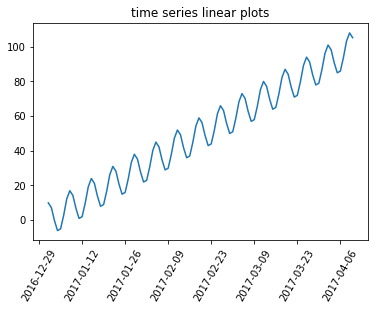

In [6]:
# model confidence in terms of time with indicators
plt.plot(learning_progress.date, learning_progress.confidence)
plt.xticks(rotation=60)
plt.title('time series linear plots')
plt.show()

- Appears to have a weekly pattern
- Model in terms of two factors
    - Trend line
    - Day of the week indicator
        - Get indicator by extracting day of the week from dates and convert to dummies

In [12]:
learning_progress['day_of_week'] = learning_progress.date.apply(
    lambda x: str(dt.datetime.weekday(x)))

X = pd.get_dummies(learning_progress.day_of_week)
X['date'] = pd.to_numeric(learning_progress.date) / (1000000000*24*60*60)
y = learning_progress['confidence']
lm.fit(X,y)
lm.score(X,y)

1.0

In [13]:
print(X.columns)
print(lm.coef_)

Index(['0', '1', '2', '3', '4', '5', '6', 'date'], dtype='object')
[ 6.23489802 -2.22520934 -9.00968868 -9.00968868 -2.22520934  6.23489802
 10.          1.        ]


**Results**:
- Series of coefficients for day of the week, 0 = Monday through 6 = Sunday
- Mondays have higher confidence than Tuesdays through Fridays, and it recovers on the weekends
- Daily trend: confidence increases an average of 1 unit per day
- Model has score of 1.0, since this is the exact equation used to create the data if you discretize the oscillating function

### Oscillators
- Can also use trigonometric functions, specifically sine and cosine
- Oscillating functions: have a period and an amplitude

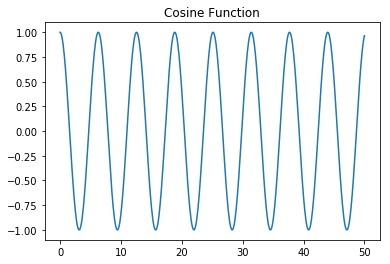

In [15]:
x = np.linspace(0, 50, 500)
plt.plot(x, np.cos(x))
plt.title('Cosine Function')
plt.show()

### Trigonometry
- Sine/cosine functions are derived from relationships from within triangles
- Using these functions not for trigonometric purposes
- Regularly repeating oscillating wave, can control height and frequency of oscillations
    - **Amplitude**: how high oscillations move from the center (in plot above amplitude = 1)
    - **Period**: how long an oscillation is (in plot period $=2\pi$)
- Working with a linear model and see something regularly oscillating in a symmetric fashion
    - Sine transformation can be useful to draw out periodicity
    - Can add a regular wiggle or movement up or day, within a period, to any other linear trends present
    - Must find the duration of oscillation before applying the sine/cosine transformation

In [16]:
X = pd.DataFrame()
X['date'] = pd.to_numeric(learning_progress.date) / (1000000000*24*60*60)

# subtracting 17167 from date to normalize it to start at zero
# this aligns the peak of the curve with the start of the cosine function

X['cos_date'] = np.cos((X.date - 17167) * np.pi / 3.5)
y = learning_progress['confidence']
lm.fit(X, y)
lm.score(X, y)

1.0

In [17]:
lm.coef_

array([ 1., 10.])

**Finding the duration of an oscillation**
- Easiest way: have its period be present in the data (eg things that repeat weekly have a weekly period)
- Period is not always clear, eg see something monthly but doesn't line up perfectly with clear starts/ends
- For these cases, use **spectral analysis**:
    - Implementation is beyond scope here
    - In practice, can usually attain a reasonable estimation through indicators and other techniques

**Main value of trigonometric terms for seasonality**
- Avoid overfitting by only offering a single term to match, the amplitude
- Overfitting opportunity: also manually estimating period
    - 12 indicators: much more opportunity to overfit
    - 1 indicator: much less opportunity to overfit